In [51]:
import pandas as pd
import torch
from datasets import Dataset
import datasets
import os
import random
import numpy as np
import re
from copy import deepcopy
import json
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from nlpcda import Similarword


def seedeverything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  ##
    torch.backends.cudnn.benchmark = True

seedeverything(seed=233)

traindata = pd.read_json('./CHIP-CTC/CHIP-CTC_train.json')
valdata = pd.read_json('./CHIP-CTC/CHIP-CTC_dev.json')
testdata = pd.read_json('./CHIP-CTC/CHIP-CTC_test.json')
testdata_temp = deepcopy(testdata)

print(traindata.head())

   id               label                                    text
0  s1  Therapy or Surgery                  研究开始前30天内，接受过其他临床方案治疗；
1  s2                Sign                          （9）严重的听力或者视力损害
2  s3  Addictive Behavior   10)现在或曾经滥用药物或酗酒，或者每天饮用相当于30毫升酒精的酒精饮料。
3  s4                 Age                              4.年龄小于65岁。
4  s5             Disease                               ⑧有精神疾病患者；


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns




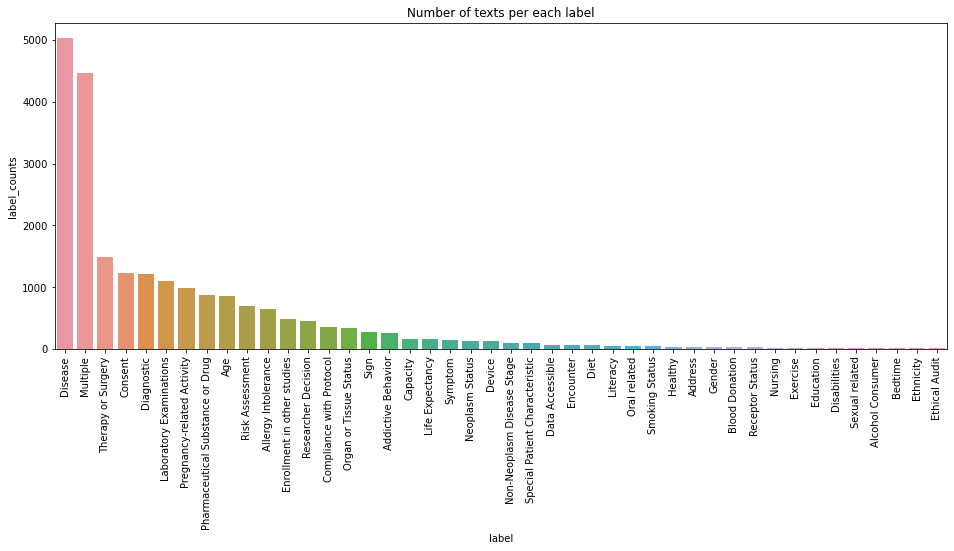

In [53]:
temp = traindata.groupby(["label"])['text'].nunique()
df = pd.DataFrame({'label': temp.index,
                   'label_counts': temp.values
                  })
df = df.sort_values(['label_counts'], ascending=False).head(50)
plt.figure(figsize = (16,6))
plt.title(f'Number of texts per each label')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'label', y="label_counts", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [54]:
print(df.head())
label2num = dict(zip(df['label'],df['label_counts']))
print(label2num)
print(label2num['Therapy or Surgery'])



                 label  label_counts
15             Disease          5023
27            Multiple          4461
43  Therapy or Surgery          1487
9              Consent          1226
12          Diagnostic          1210
{'Disease': 5023, 'Multiple': 4461, 'Therapy or Surgery': 1487, 'Consent': 1226, 'Diagnostic': 1210, 'Laboratory Examinations': 1105, 'Pregnancy-related Activity': 981, 'Pharmaceutical Substance or Drug': 866, 'Age': 855, 'Risk Assessment': 694, 'Allergy Intolerance': 648, 'Enrollment in other studies': 494, 'Researcher Decision': 453, 'Compliance with Protocol': 354, 'Organ or Tissue Status': 344, 'Sign': 279, 'Addictive Behavior': 261, 'Capacity': 165, 'Life Expectancy': 164, 'Symptom': 145, 'Neoplasm Status': 129, 'Device': 126, 'Non-Neoplasm Disease Stage': 102, 'Special Patient Characteristic': 100, 'Data Accessible': 71, 'Encounter': 65, 'Diet': 61, 'Literacy': 52, 'Oral related': 51, 'Smoking Status': 49, 'Healthy': 35, 'Address': 31, 'Gender': 30, 'Blood Donat

In [55]:
temp = traindata.iloc[0]
temp = temp.to_frame()
temp = pd.DataFrame(temp.values.T,columns=temp.index)
temp =pd.concat([temp]*3,ignore_index=True)
temp['text'] = ['dasdasdas','dasdasdas','dasdasdas']
tmp = traindata[:5]
tmp = pd.concat([tmp,temp], ignore_index=True)
print(tmp)


   id               label                                    text
0  s1  Therapy or Surgery                  研究开始前30天内，接受过其他临床方案治疗；
1  s2                Sign                          （9）严重的听力或者视力损害
2  s3  Addictive Behavior   10)现在或曾经滥用药物或酗酒，或者每天饮用相当于30毫升酒精的酒精饮料。
3  s4                 Age                              4.年龄小于65岁。
4  s5             Disease                               ⑧有精神疾病患者；
5  s1  Therapy or Surgery                               dasdasdas
6  s1  Therapy or Surgery                               dasdasdas
7  s1  Therapy or Surgery                               dasdasdas


In [56]:
import pandas as pd
import torch
from datasets import Dataset
import datasets
import os
import random
import numpy as np
import re
from copy import deepcopy
import json
import math
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm
from nlpcda import Similarword
from nlpcda import RandomDeleteChar
from nlpcda import baidu_translate
from nlpcda import CharPositionExchange

def seedeverything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  ##
    torch.backends.cudnn.benchmark = True

seedeverything(seed=233)

traindata = pd.read_json('./CHIP-CTC/CHIP-CTC_train.json')
valdata = pd.read_json('./CHIP-CTC/CHIP-CTC_dev.json')
testdata = pd.read_json('./CHIP-CTC/CHIP-CTC_test.json')
testdata_temp = deepcopy(testdata)       
        

In [57]:
class TextAugmentation:
    def __init__(self,traindata,valdata,testdata,label2num,padding,change_rate):
        super(TextAugmentation, self).__init__()
        self.traindata = traindata
        self.valdata = valdata
        self.testdata = testdata
        self.label2num = label2num
        self.padding = padding
        self.change_rate = change_rate
    
    def textclean(self,x):
        a = re.findall('[\u4e00-\u9fa5A-Za-z][\S\s]+',x,re.S)  
        a = "".join(a)
        return a

    def TextProcess(self):
        self.traindata['text'] = self.traindata['text'].apply(lambda x: self.textclean(x))
        self.valdata['text'] = self.valdata['text'].apply(lambda x: self.textclean(x))
        self.testdata['text'] = self.testdata['text'].apply(lambda x: self.textclean(x))

    def TextAug(self):
        self.traindata['res'] = ""
        for i in range(self.traindata.shape[0]):
            if self.padding > self.label2num[self.traindata.iloc[i,1]]:
                res = max(math.ceil(math.sqrt((self.padding - self.label2num[self.traindata.iloc[i,1]])/self.label2num[self.traindata.iloc[i,1]])),1)
            else:
                res = 1
            self.traindata.iloc[i,3] = res
        
        for i in tqdm(range(self.traindata.shape[0])):
            a = self.traindata.iloc[i,2]
            res = self.traindata.iloc[i,3]
            smw = CharPositionExchange(create_num=res, change_rate=self.change_rate,char_gram=3)
            rs1 = smw.replace(a)[1:]
            if len(rs1) > 0:
                temp = self.traindata.iloc[i]
                temp = temp.to_frame()
                temp = pd.DataFrame(temp.values.T,columns=temp.index)
                temp = pd.concat([temp]*len(rs1),ignore_index=True)
                temp['text'] = rs1
                self.traindata = pd.concat([self.traindata,temp], ignore_index=True) 
                
        for i in tqdm(range(self.traindata.shape[0])):
            a = self.traindata.iloc[i,2]
            res = self.traindata.iloc[i,3]
            smw = RandomDeleteChar(create_num=res, change_rate=self.change_rate)
            rs1 = smw.replace(a)[1:]
            if len(rs1) > 0:
                temp = self.traindata.iloc[i]
                temp = temp.to_frame()
                temp = pd.DataFrame(temp.values.T,columns=temp.index)
                temp = pd.concat([temp]*len(rs1),ignore_index=True)
                temp['text'] = rs1
                self.traindata = pd.concat([self.traindata,temp], ignore_index=True)

    def get_aug_text(self):
        return self.traindata,self.valdata,self.testdata

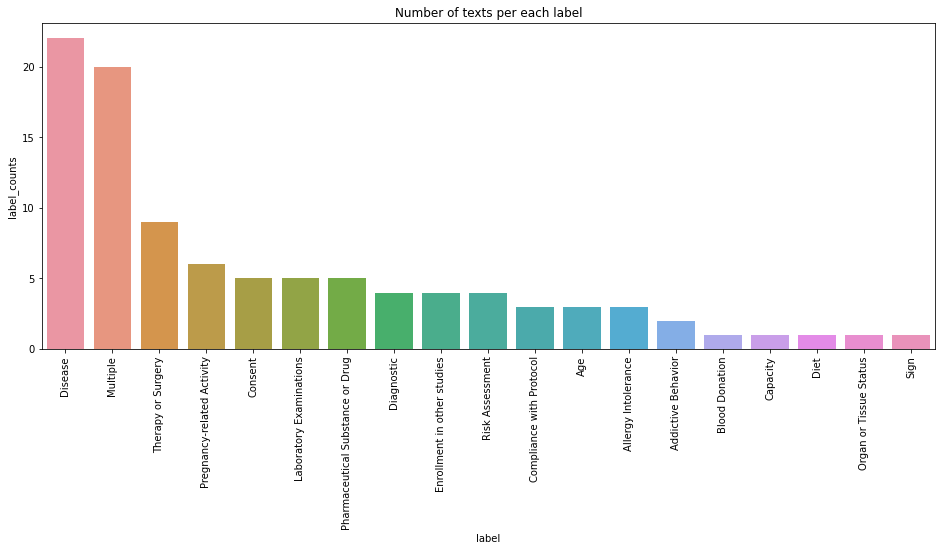

In [58]:
temp_train_data = traindata
df = temp_train_data
temp = df.groupby(["label"])['text'].nunique()
df = pd.DataFrame({'label': temp.index,
                   'label_counts': temp.values
                  })
df = df.sort_values(['label_counts'], ascending=False).head(50)
plt.figure(figsize = (16,6))
plt.title(f'Number of texts per each label')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'label', y="label_counts", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [59]:
for i in range(temp_train_data.shape[0]):
    if traindata.iloc[i,1] == 'Age':
        a = traindata.iloc[i,2]
        smw = Similarword(create_num=2, change_rate=0.3)
        rs1 = smw.replace(a)
        print('随机同义词替换>>>>>>')
        print(rs1[1:])
        for s in rs1:
            print(s)

load :/home/gray/.conda/envs/python37/lib/python3.7/site-packages/nlpcda/data/同义词.txt done
随机同义词替换>>>>>>
['4.年纪仅次于65岁。']
4.年龄小于65岁。
4.年纪仅次于65岁。
load :/home/gray/.conda/envs/python37/lib/python3.7/site-packages/nlpcda/data/同义词.txt done
随机同义词替换>>>>>>
['2.年纪65-80岁（含65岁）']
2.年龄65-80岁（含65岁）
2.年纪65-80岁（含65岁）
load :/home/gray/.conda/envs/python37/lib/python3.7/site-packages/nlpcda/data/同义词.txt done
随机同义词替换>>>>>>
['1)年纪：25-45岁，赅25和45岁。']
1)年龄：25-45岁，包括25和45岁。
1)年纪：25-45岁，赅25和45岁。


In [60]:

label2num = dict(zip(df['label'],df['label_counts']))
text_aug = TextAugmentation(temp_train_data,valdata,testdata,label2num,padding=1500,change_rate=0.3)
text_aug.TextProcess()
text_aug.TextAug()
traindata,valdata,testdata = text_aug.get_aug_text()

print(len(traindata))
print(len(valdata))
print(len(testdata))




/home/gray/.conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/gray/.conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/gray/.conda/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

398
100
100


      id               label                                text res
0     s1  Therapy or Surgery              研究开始前30天内，接受过其他临床方案治疗；   2
1     s2                Sign                         严重的听力或者视力损害   5
2     s3  Addictive Behavior  现在或曾经滥用药物或酗酒，或者每天饮用相当于30毫升酒精的酒精饮料。   3
3     s4                 Age                            年龄小于65岁。   3
4     s5             Disease                            有精神疾病患者；   1
..   ...                 ...                                 ...  ..
393  s98                 Age                   龄年：25-45岁括包25和45岁   3
394  s99  Addictive Behavior                       怀确或疑酒精、药滥者史物用   3
395  s99  Addictive Behavior                       怀确或疑有酒精药滥者史物用   3
396  s99  Addictive Behavior                       确疑怀有酒精、药物滥用史者   3
397  s99  Addictive Behavior                       确疑或怀有酒精药物滥用史者   3

[398 rows x 4 columns]


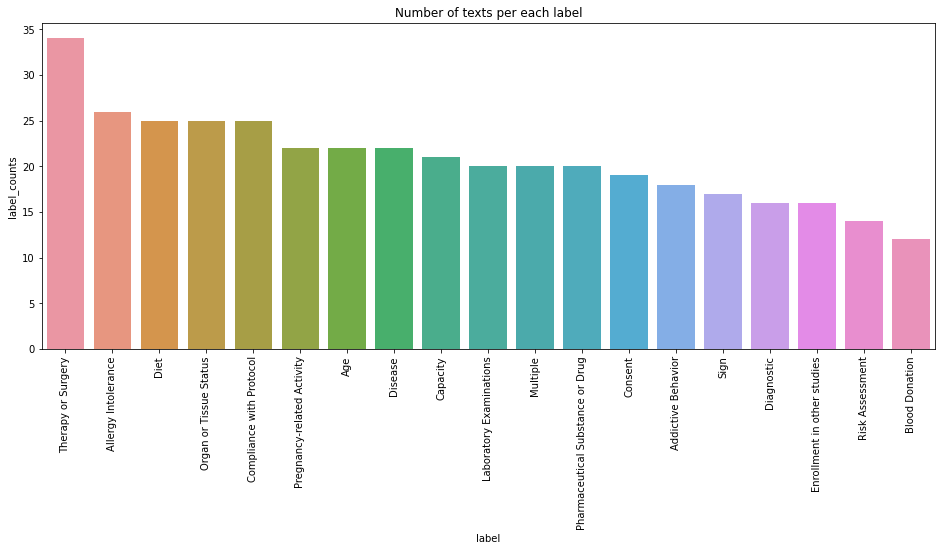

In [61]:
df = traindata
print(traindata)
temp = df.groupby(["label"])['text'].nunique()
df = pd.DataFrame({'label': temp.index,
                   'label_counts': temp.values
                  })
df = df.sort_values(['label_counts'], ascending=False).head(50)
plt.figure(figsize = (16,6))
plt.title(f'Number of texts per each label')
sns.set_color_codes("pastel")
s = sns.barplot(x = 'label', y="label_counts", data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

1
1
1
